In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 3.3 MB 45.0 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models.resnet as resnet
from transformers import AdamW

TRAIN_DIR = '/content/drive/MyDrive/KK/TRAIN'
TEST_DIR = '/content/drive/MyDrive/KK/TEST'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from torchvision import models
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 27)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = dsets.ImageFolder(TRAIN_DIR, transform=transform)
test_data = dsets.ImageFolder(TEST_DIR, transform=transform)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
t_accs, v_accs, t_loss, v_loss = [], [], [], []
epochs=25
criterion = nn.CrossEntropyLoss().cuda()
optimizer = AdamW(model.parameters(), lr=1e-5)

for epoch in range(epochs):
  train_loss = 0
  train_accuracy = 0
  model.train()

  for images, labels in trainloader:
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    output = model(images)
    ps = torch.exp(output) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  
  t_accs.append(train_accuracy/len(trainloader))
  t_loss.append(train_loss/len(trainloader))

  test_loss = 0
  test_accuracy = 0
  model.eval()

  for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    log_ps = model(images)
    test_loss += criterion(log_ps, labels).item()

    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  v_accs.append(test_accuracy/len(testloader))
  v_loss.append(test_loss/len(testloader))

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))


  model_out_path = '.model.pth'
  torch.save(model.state_dict(), model_out_path)


==> Epoch[1/25]
loss: 3.016, Accuracy: 0.228, val_loss: 2.697, val_accuracy: 0.367
==> Epoch[2/25]
loss: 2.197, Accuracy: 0.585, val_loss: 2.032, val_accuracy: 0.544
==> Epoch[3/25]
loss: 1.529, Accuracy: 0.728, val_loss: 1.483, val_accuracy: 0.689
==> Epoch[4/25]
loss: 1.010, Accuracy: 0.849, val_loss: 1.007, val_accuracy: 0.799
==> Epoch[5/25]
loss: 0.651, Accuracy: 0.914, val_loss: 0.749, val_accuracy: 0.838
==> Epoch[6/25]
loss: 0.436, Accuracy: 0.935, val_loss: 0.562, val_accuracy: 0.875
==> Epoch[7/25]
loss: 0.293, Accuracy: 0.956, val_loss: 0.482, val_accuracy: 0.878
==> Epoch[8/25]
loss: 0.217, Accuracy: 0.961, val_loss: 0.427, val_accuracy: 0.880
==> Epoch[9/25]
loss: 0.161, Accuracy: 0.969, val_loss: 0.414, val_accuracy: 0.878
==> Epoch[10/25]
loss: 0.123, Accuracy: 0.977, val_loss: 0.379, val_accuracy: 0.889
==> Epoch[11/25]
loss: 0.106, Accuracy: 0.977, val_loss: 0.387, val_accuracy: 0.878
==> Epoch[12/25]
loss: 0.095, Accuracy: 0.972, val_loss: 0.372, val_accuracy: 0.886
=

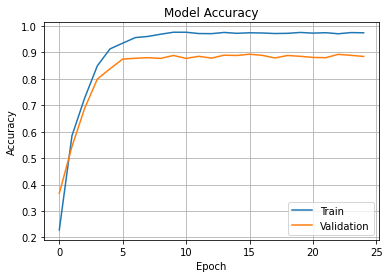

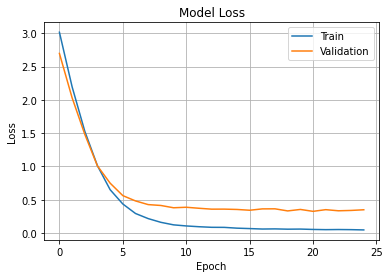

In [13]:
import matplotlib.pyplot as plt

plt.title('Model Accuracy')
plt.plot(t_accs, label= "Training Accuracy") 
plt.plot(v_accs, label= "Validation Accuracy") 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

plt.title('Model Loss')
plt.plot(t_loss, label = "Training loss") 
plt.plot(v_loss, label = "Validation loss") 
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

In [28]:
def SortHat(img):
  trans_img = transform(img)
  trans_img = Variable(trans_img)
  ti = trans_img.unsqueeze(0)
  ti = ti.cuda()
  output = model(ti).cuda()
  _, predicted = torch.max(output.cpu().data, 1)
  pred = predicted[0]

  if 0<=pred<=11:
    print('Slytherin!')
  elif 12<=pred<=18:
    print('Ravenclaw!')
  elif 19<=pred<=26:
    print('Griffyndor!')

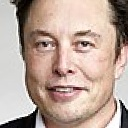

Slytherin!


In [30]:
REAL_IMG = '/content/drive/MyDrive/KK/REAL_WORLD/1.jpg'
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(REAL_IMG)
cv2_imshow(img)
SortHat(img)

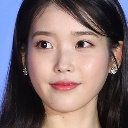

Ravenclaw!


In [31]:
REAL_IMG = '/content/drive/MyDrive/KK/REAL_WORLD/2.jpg'
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(REAL_IMG)
cv2_imshow(img)
SortHat(img)

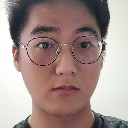

Griffyndor!


In [32]:
REAL_IMG = '/content/drive/MyDrive/KK/REAL_WORLD/3.jpg'
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(REAL_IMG)
cv2_imshow(img)
SortHat(img)